#### **Multi-Layer-perceptron (MLP)**

Based on and with modifications from  of http://d2l.ai/chapter_multilayer-perceptrons/mlp.html

**Deep dive into DL algorithms**: Discuss the gradient calculation and backpropagation, numerical stability and parameter initialization.


Multi-layer perceptrons (MLPs) overcome the limitations of linear models like softmax regression by incorporating hidden layers. While a stack of purely affine transformations remains linear, the addition of a non-linear activation function, such as ReLU, between layers allows MLPs to learn complex, non-linear relationships. This enables the model to be more expressive as hidden layers are stacked, with each layer's activations feeding into the next. The training process involves calculating gradients via backpropagation to update the model's parameters.

In [4]:
import dl_modules

Activation functions

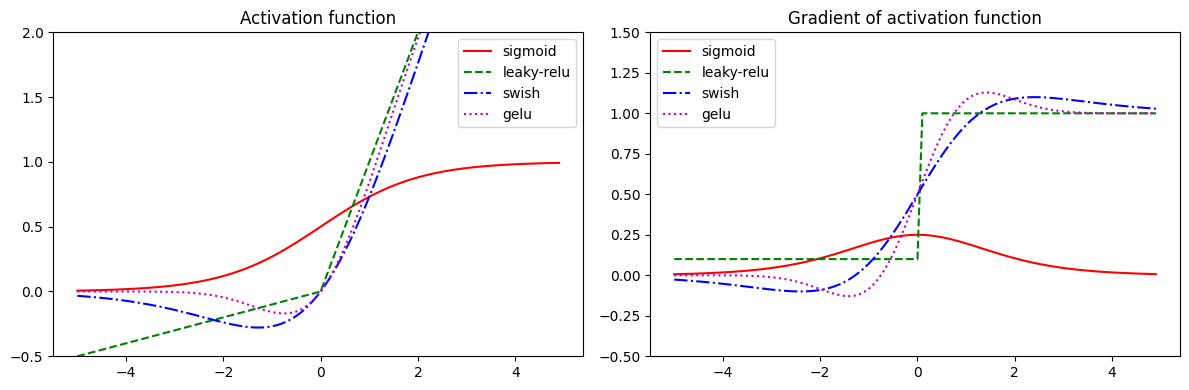

In [27]:
'''
We incorporate the nonlinearities to build expressive multi-layer NN
ReLU is significantly more amenable to sigmoid or tanh - and the key innovation
in DL. The GeLU (Gaussian error linear unit) is the standard gaussian cummulative
distribution function and Swish can yield better accurate results in some cases.
'''
x = torch.arange(-5, 5, 0.1, requires_grad=True)
fns = [
    torch.sigmoid,
    torch.nn.LeakyReLU(negative_slope=.1),
    torch.nn.SiLU(),
    torch.nn.GELU()
]
names = ['sigmoid', 'leaky-relu', 'swish', 'gelu']

''' evaluate functions and their gradients on a grid of points '''
xs = x.detach()
f_dict, g_dict = {}, {}
for i in range(len(fns)):
  fn = fns[i]
  name = names[i]
  y = fn(x)
  f_dict[name] = y.detach()
  y.backward(torch.ones_like(x), retain_graph=True)
  g_dict[name] = torch.clone(x.grad)
  x.grad.data.zero_()

styles = ["r-", "g--", "b-.", "m:", "k-"]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the functions on the first subplot
ax1 = axs[0]
for i, name in enumerate(names):
    lab = f"{name}"
    ax1.plot(xs, f_dict[name], styles[i], label=lab)
ax1.set_ylim(-0.5, 2) ; ax1.legend() ; ax1.set_title("Activation function")

# Plot the gradients on the second subplot
ax2 = axs[1]
for i, name in enumerate(names):
    lab = f"{name}"
    ax2.plot(xs, g_dict[name], styles[i], label=lab)
ax2.set_ylim(-0.5, 1.5) ; ax2.legend() ; ax2.set_title("Gradient of activation function")

plt.tight_layout()  ; plt.show()

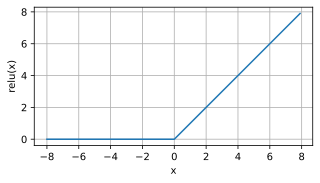

In [36]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = F.relu(x)
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach().numpy(), y.detach().numpy(), 'x', 'relu(x)', figsize=(5, 2.5))

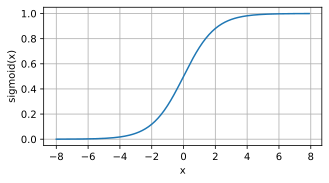

In [37]:
y = torch.sigmoid(x)
# clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach().numpy(), y.detach().numpy(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

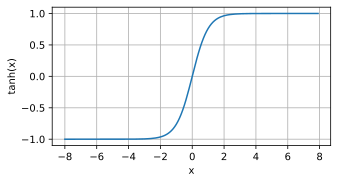

In [38]:
y = torch.tanh(x)
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach().numpy(), y.detach().numpy(), 'x', 'tanh(x)', figsize=(5, 2.5))

MLP Implementation

In [97]:
class MLP_(Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) *sigma)
    self.b1 = nn.Parameter(torch.zeros(num_hiddens))
    self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) *sigma)
    self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [98]:
##@add_to_class(MLP_)
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(X, a)

@add_to_class(MLP_)
def forward(self, X):
  X = X.reshape(-1, self.num_inputs)
  H = relu(torch.matmul(X, self.W1) + self.b1)
  return torch.matmul(H,self.W2) + self.b2

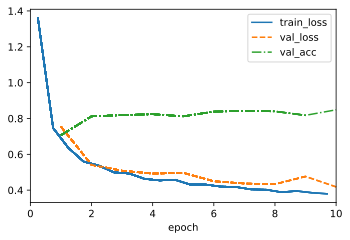

In [101]:
model = MLP_(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

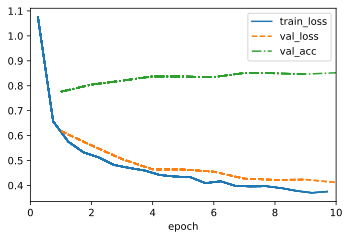

In [104]:
class MLP__(Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs) )

model = MLP__(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

Concise Implementation

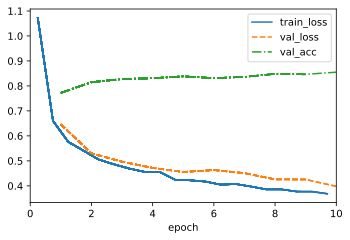

In [105]:
class MLP(Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    self.net = nn.Sequential(
        nn.Flatten(), nn.LazyLinear(num_hiddens),
        nn.ReLU(), nn.LazyLinear(num_outputs) )

model = MLP(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

Numerical Stability

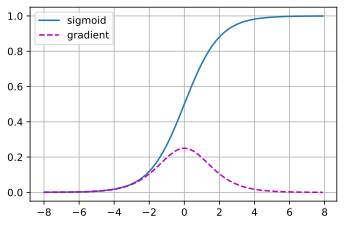

In [172]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
     legend=['sigmoid', 'gradient'], figsize=(5.5, 3.5))

In [114]:
''' exploding gradients '''
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n', M)
for i in range(100):
  M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))
print('a matrix after multiplying 100 times \n', M)

a single matrix 
 tensor([[-0.2680,  0.3842,  1.2392,  0.1148],
        [ 0.1232, -1.4652, -0.8490,  0.8592],
        [-0.7255, -0.3558,  0.5231, -0.9758],
        [-0.6024, -1.0187,  0.0103,  1.4211]])
a matrix after multiplying 100 times 
 tensor([[-4.7252e+22, -3.6994e+22, -6.8203e+21, -7.2267e+22],
        [ 4.3044e+22,  3.3699e+22,  6.2129e+21,  6.5831e+22],
        [ 1.1121e+23,  8.7065e+22,  1.6051e+22,  1.7008e+23],
        [-2.5354e+21, -1.9850e+21, -3.6596e+20, -3.8777e+21]])


Dropout

In [173]:
''' Implement dropout layer '''
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  if dropout == 1: return torch.zeros_like(X)
  if dropout == 0: return X
  mask = (torch.rand(X.shape) > dropout).float()
  out = mask * X / (1.0 - dropout)
  return out.to(device)

X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print('dropout =0:', dropout_layer(X, 0.))
print('dropout =0.5:', dropout_layer(X, 0.5))
print('dropout =1:', dropout_layer(X, 0.5))

dropout =0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout =0.5: tensor([[ 0.,  0.,  4.,  6.,  0.,  0., 12.,  0.],
        [16.,  0.,  0., 22.,  0.,  0.,  0., 30.]], device='cuda:0')
dropout =1: tensor([[ 0.,  0.,  0.,  6.,  0., 10.,  0.,  0.],
        [ 0., 18., 20.,  0., 24.,  0.,  0.,  0.]], device='cuda:0')


In [174]:
device = torch.device('cuda' ) ##if torch.cuda.is_available() else 'cpu')

Define the Model with the Dropout

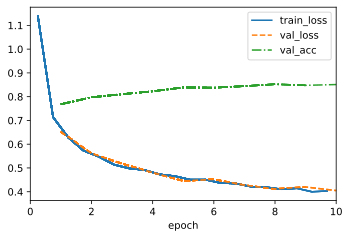

In [123]:
class MLP(Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    self.net = nn.Sequential(
        nn.Flatten(), nn.LazyLinear(num_hiddens), nn.Dropout(0.5),
        nn.ReLU(), nn.LazyLinear(num_outputs) )

model = MLP(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

Redefine the Model from Scratch with Dropout

In [176]:
class MLP_v2(Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
               dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.dropout_1 = dropout_1
    self.dropout_2 = dropout_2

    self.linear_1 = nn.LazyLinear(num_hiddens_1)
    self.linear_2 = nn.LazyLinear(num_hiddens_2)
    self.linear_3 = nn.LazyLinear(num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    H1 = self.relu(self.linear_1(X.reshape((X.shape[0], -1))))
    if self.training == True:
      H1 = dropout_layer(H1, self.dropout_1)
    H2 = self.relu(self.linear_2(H1))
    if self.training == True:
      H2 = dropout_layer(H2, self.dropout_2)
    out = self.linear_3(H2)
    return out.to(device)

hparams = { 'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
    'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1 }
model = MLP_v2(**hparams)
model.eval()
model.to(device)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

Concise Model with Dropout

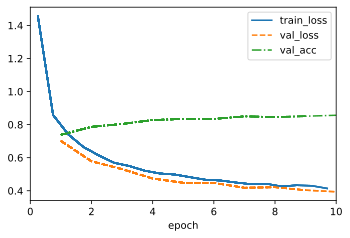

In [177]:
class MLP_Dropout(Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
               dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()

    self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs) )

model = MLP_Dropout(**hparams)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)